# Taks 1: Data scraping

The codes for Task 1: 

**XJTLU**  
**Name**: Jingcheng Li  
**ID**: 2034306 

In [3]:
import re
import time
import random
# Python built-in library for comparing objects (str in this project)
import difflib
import requests
import numpy as np
# Library for parsing the search query to standardized format required by a url
import urllib.parse
import pandas as pd
from tqdm import tqdm  # Library to make progress bars
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline


def get_pages_soups():
    """Iteratively scrape the urls of each page containing ten quotes"""
    base_url = 'http://quotes.toscrape.com'
    for i in range(1, 11):
        url = f'{base_url}/page/{i}/'
        result = requests.get(url)
        # Use UTF-8 encoding to decode the webpage to avoid garbled code problem
        result.encoding = 'utf-8'
        # Parse the html with BeautifulSoup
        soup = BeautifulSoup(result.text, 'html.parser')
        yield soup

In [4]:
def get_quotes_detail(soup):
    """Get the detailed information of quotes in each page"""
    base_url = 'http://quotes.toscrape.com'
    quote_df = pd.DataFrame()
    # Get each ten quotes in one page
    quotes = soup.find_all('div', class_='quote')
    # Get details of each quote
    for i in range(0,10):
        # Get the content
        content = quotes[i].span.text.strip()
        # Get the tags
        tags = quotes[i].div.contents[1].get('content')
        # Get the auther name
        author = quotes[i].small.text
        # Get auther details
        au_link = quotes[i].a.get('href')
        au_url = f'{base_url}{au_link}'
        au_result = requests.get(au_url)
        au_result.encoding = 'utf-8'
        au_soup = BeautifulSoup(au_result.text, 'html.parser')
        # Get auther's birthday
        birthday = au_soup.find('span', class_='author-born-date').contents[0]
        # Get auther's country
        country = au_soup.find('span', class_='author-born-location').contents[0]
        # Get auther's description
        description = au_soup.find('div', class_='author-description').contents[0].strip()
        # Quote info dict
        inform = {'content': content, 'tags': tags, 'author_name': author, 'birthday': birthday,
              'country': country, 'description': description}
        quote_df = pd.concat([quote_df, pd.Series(inform)],
                                     axis=1, ignore_index=True)  
    return quote_df

In [22]:
def scrape_all_quotes():
    # Make a nice looking progress bar with tqdm and the context manager
    pages_df = pd.DataFrame()
    with tqdm(total=10) as pbar:
        # Set the title of the progress bar
        pbar.set_description('Scraping all quotes in 10 pages')
        # This is each page
        for page_soup in get_pages_soups():
            # Sleep for a while to prevent the server from crashing down
            time.sleep(0.5 * random.random())
            page_details = get_quotes_detail(page_soup)
            # Store the book info to the books dataframe
            pages_df = pd.concat([pages_df, page_details],
                                     axis=1, ignore_index=True)    
            # Update the progress bar manually
            pbar.update(1)
    # Transpose the dataframe to make the attributes as columns
    pages_df = pages_df.T
    return pages_df
    
pages_df = scrape_all_quotes()
pages_df.head()
pages_df.to_csv("Jingcheng_Li_2034306.csv",index = False)

Scraping all quotes in 10 pages: 100%|██████████| 10/10 [02:01<00:00, 12.17s/it]


# Task 2: Data analysis

# Topic: How to find a suitable collection of quotes with the help of this website?


## Background

Whether it is a school requirement or a personal hobby, many students want to have a book of famous quotes to their satisfaction. However, due to a lack of knowledge about famous people, it is difficult for students to buy targeted collections of quotes that they really like. As a student, if I can use the website's data to clearly understand what types of quotes work best for me and what quotes my favorite celebrities have, then I can quickly buy a collection of quotes that I want. To address this need, I will categorize the captured 100 quotes, filter and extract them by label or author categories to provide suggestions and supports to different consumers with various needs.

## Initial data

Initial data has already been collected by scraping. Below is some of the data:

In [5]:
pages_df = pd.read_csv('./Jingcheng_Li_2034306.csv')
pages_df.head()

,content,tags,author_name,birthday,country,description
0,“The world as we have created it is a process ...,"change,deep-thoughts,thinking,world",Albert Einstein,"March 14, 1879","in Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ..."
1,"“It is our choices, Harry, that show what we t...","abilities,choices",J.K. Rowling,"July 31, 1965","in Yate, South Gloucestershire, England, The U...",See also: Robert GalbraithAlthough she writes ...
2,“There are only two ways to live your life. On...,"inspirational,life,live,miracle,miracles",Albert Einstein,"March 14, 1879","in Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ..."
3,"“The person, be it gentleman or lady, who has ...","aliteracy,books,classic,humor",Jane Austen,"December 16, 1775","in Steventon Rectory, Hampshire, The United Ki...",Jane Austen was an English novelist whose work...
4,"“Imperfection is beauty, madness is genius and...","be-yourself,inspirational",Marilyn Monroe,"June 01, 1926",in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...


## Process data from different perspectives


### Filter the authors

It is important to dig out your favorite author from the information of many authors. For example, the authors who publish the most famous quotes tend to be the ones who are better known to the public, and also the ones who are better liked by the public. So if we haven't already decided which author's collection of quotes to buy, this data will give us potential options.

In this DataFrame, we will only care about information relating to each author like `author_name`, and count the total number of quotes generated from each author with the help of reduce methods. The number of quotes per author will be in the last column `num_quotes` of the newly generated table.

In [14]:
# Get author information
def extract_author_info(row):
    author_info = {
        'author_name': row['author_name'],
        'birthday': row['birthday'],
        'country': row['country'],
        'description': row['description']
    }
    return author_info

author_info_list = pages_df.apply(extract_author_info, axis=1)


# Calculate the appearance times of each author
def count_authors(accumulator, current_author_info):
    author_name = current_author_info['author_name']
    if author_name in accumulator:
        accumulator[author_name] += 1
    else:
        accumulator[author_name] = 1
    return accumulator

author_counts = reduce(count_authors, author_info_list, {})

# Create new df for authors
authors = []
for author_info in author_info_list:
    author_name = author_info['author_name']
    author_info['num_quotes'] = author_counts[author_name]
    authors.append(author_info)
    
authors_df = pd.DataFrame(authors).drop_duplicates()

# Reset the index
authors_df.index = range(1, len(authors_df)+1)


authors_df.head()


,author_name,birthday,country,description,num_quotes
1,Albert Einstein,"March 14, 1879","in Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",10
2,J.K. Rowling,"July 31, 1965","in Yate, South Gloucestershire, England, The U...",See also: Robert GalbraithAlthough she writes ...,9
3,Jane Austen,"December 16, 1775","in Steventon Rectory, Hampshire, The United Ki...",Jane Austen was an English novelist whose work...,5
4,Marilyn Monroe,"June 01, 1926",in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,7
5,André Gide,"November 22, 1869","in Paris, France",André Paul Guillaume Gide was a French author ...,1


To make the data more intuitive, we arrange it in descending order by `num_quotes` rows.

In [15]:
author_df = authors_df.sort_values(by='num_quotes', ascending=False)
author_df.index = range(1, len(authors_df)+1)
author_df.head()

,author_name,birthday,country,description,num_quotes
1,Albert Einstein,"March 14, 1879","in Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",10
2,J.K. Rowling,"July 31, 1965","in Yate, South Gloucestershire, England, The U...",See also: Robert GalbraithAlthough she writes ...,9
3,Marilyn Monroe,"June 01, 1926",in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,7
4,Dr. Seuss,"March 02, 1904","in Springfield, MA, The United States",Theodor Seuss Geisel was born 2 March 1904 in ...,6
5,Mark Twain,"November 30, 1835","in Florida, Missouri, The United States","Samuel Langhorne Clemens, better known by his ...",6


The chart below generates a bar chart of the number of quotes published by authors. It is clear from the chart which authors publish the most quotes, so users can easily filter out the authors they want to follow：

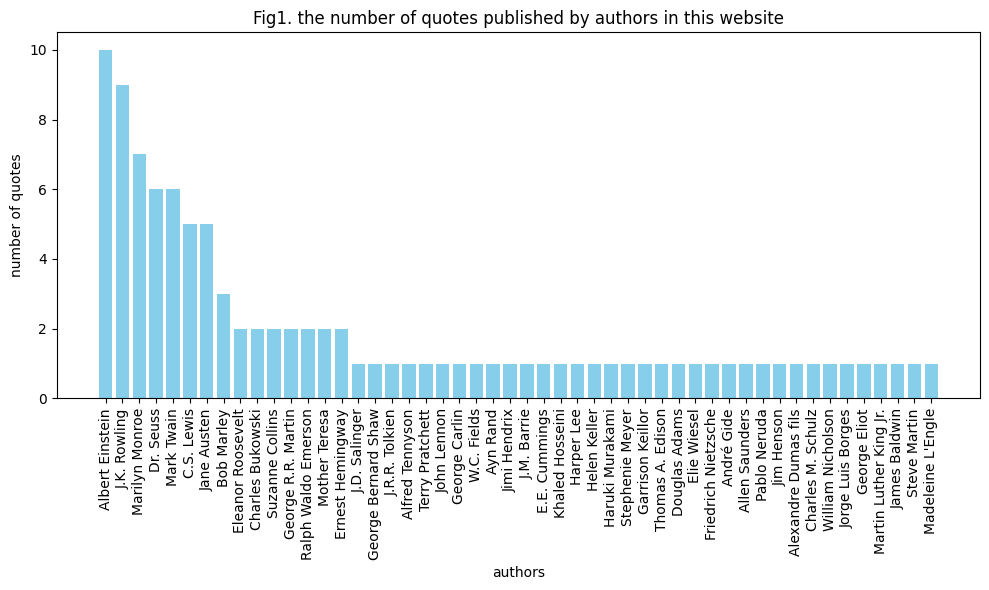

In [16]:
# Extract the name of author and the number of quotes
authors = author_df['author_name']
quote_counts = author_df['num_quotes']

# Generate bar plot
plt.figure(figsize=(10, 6))
plt.bar(authors, quote_counts, color='skyblue')
plt.xlabel('authors')
plt.ylabel('number of quotes')
plt.title('Fig1. the number of quotes published by authors in this website')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

As you can see from the above chart, the authors with the most quotes on the website are `Albert Einstein` and `J.K. Rowing`. Through this figure, readers can easily find their favorite author and find his quotes and materials in a targeted way. Since these authors come from different centuries, we can also classify them with their birth dates:

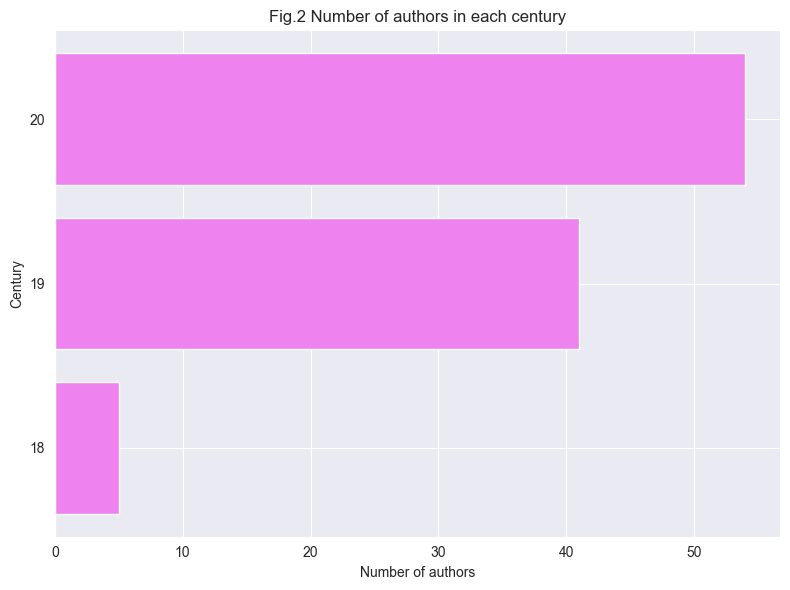

In [122]:
# Extract the year of birth
birth_df = pd.DataFrame()
birth_df['year'] = (pages_df['birthday'].str.split(',').str[1].astype(int) // 100) + 1
birth_df['author'] = pages_df['author_name']
# Group the author with each century
century_counts = birth_df.groupby('year')['author'].count()
# Draw bar plot
plt.figure(figsize=(8, 6))
plt.barh(century_counts.index, century_counts.values, color='violet')
plt.ylabel('Century')
plt.xlabel('Number of authors')
plt.title('Fig.2 Number of authors in each century')
plt.xticks(rotation=0)
min_century = birth_df['year'].min()
plt.yticks(range(min_century, min_century + len(century_counts)), [str(i) for i in range(min_century, min_century + len(century_counts))])
plt.tight_layout()
plt.show()

### Filter the country

Of course, there are plenty of readers who choose authors from specific countries without paying much attention to how many famous quotes each author has. Therefore, the research on the author's national branch is also very meaningful. Readers can choose a collection of quotes from different countries according to their needs. We further select the countries of each author from the table generated in the previous step, and make a pie chart to reflect the number of people. The table after selection is showed below:

In [17]:
def extract_country(city_country):
    parts = city_country.split(',')
    if len(parts) > 1:
        country = parts[-1].strip()  
        return country
    else:
        country = re.sub(r'in\s+','', parts[0], flags=re.IGNORECASE)
        return country
    
# Extract country
au_country_df = pd.DataFrame(author_df['country'].apply(lambda x: extract_country(str(x))))
au_country_df.head()

,country
1,Germany
2,The United Kingdom
3,The United States
4,The United States
5,The United States


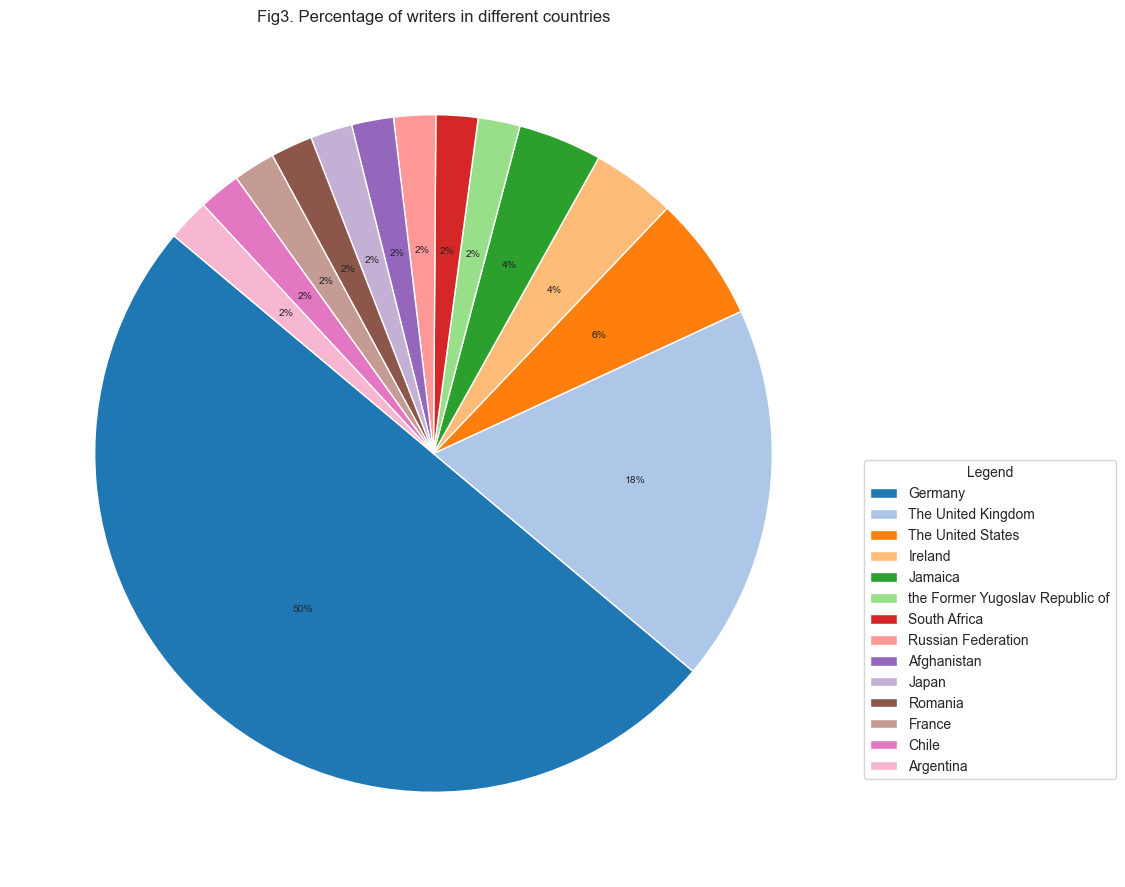

In [114]:
# Get the color
colors = plt.cm.tab20.colors
# Generate pie plot
plt.figure(figsize=(11, 11))
plt.pie(au_country_df['country'].value_counts(), autopct='%1.0f%%', startangle=140, colors=colors, textprops={'fontsize': 7.5})
plt.title('Fig3. Percentage of writers in different countries')
# Add legend
plt.legend(labels=au_country_df['country'].drop_duplicates(), title='Legend', loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

According to the figure above, most of the quotes included on the website come from Germany writers, followed by the United Kingdom, the United States and so on. Users can easily understand where these quotes come from with the help of this chart, so that it is very convenient for the website users to identify their own purchase direction.

### Rating the author

We mentioned above that one selection criterion is based on the number of quotes published by each author. We can establish a new rating system based on [Fig1]: authors who publish eight or more quotes get three points out of a total score of three whereas authors with six to eight publications received a score of 2.5. Moreover, authors who have between four and six quotes get two points whereas authors with more than two and no more than four quotes receive 1.5 points. Finally, all authors who publish only one quote receive 1 point. With reference to such rating criteria, we can evaluate each author and add the score to the `Rating` column.

In [19]:
# Calculate rating row
def calculate_rating(row):
    if row['num_quotes'] >= 8:
        return 3
    elif 6 <= row['num_quotes'] < 8:
        return 2.5
    elif 4 <= row['num_quotes'] < 6:
        return 2
    elif 2 <= row['num_quotes'] < 4:
        return 1.5
    elif row['num_quotes'] == 1:
        return 1
    else:
        return 0 
    
authors_df['Rating'] = authors_df.apply(calculate_rating, axis=1)
authors_df.head()

,author_name,birthday,country,description,num_quotes,Rating
1,Albert Einstein,"March 14, 1879","in Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",10,3.0
2,J.K. Rowling,"July 31, 1965","in Yate, South Gloucestershire, England, The U...",See also: Robert GalbraithAlthough she writes ...,9,3.0
3,Jane Austen,"December 16, 1775","in Steventon Rectory, Hampshire, The United Ki...",Jane Austen was an English novelist whose work...,5,2.0
4,Marilyn Monroe,"June 01, 1926",in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,7,2.5
5,André Gide,"November 22, 1869","in Paris, France",André Paul Guillaume Gide was a French author ...,1,1.0


Since the writers are from different countries, we can classify each writer according to the country to which they belong and give those countries a score. The size of the score is obtained by calculating the average score of all writers belonging to the country.

In [35]:
rate_country_df = pd.DataFrame(authors_df['country'].apply(lambda x: extract_country(str(x))))
rate_country_df['Rating'] = authors_df['Rating']
rate_country_df.head()

,country,Rating
1,Germany,3.0
2,The United Kingdom,3.0
3,The United Kingdom,2.0
4,The United States,2.5
5,France,1.0


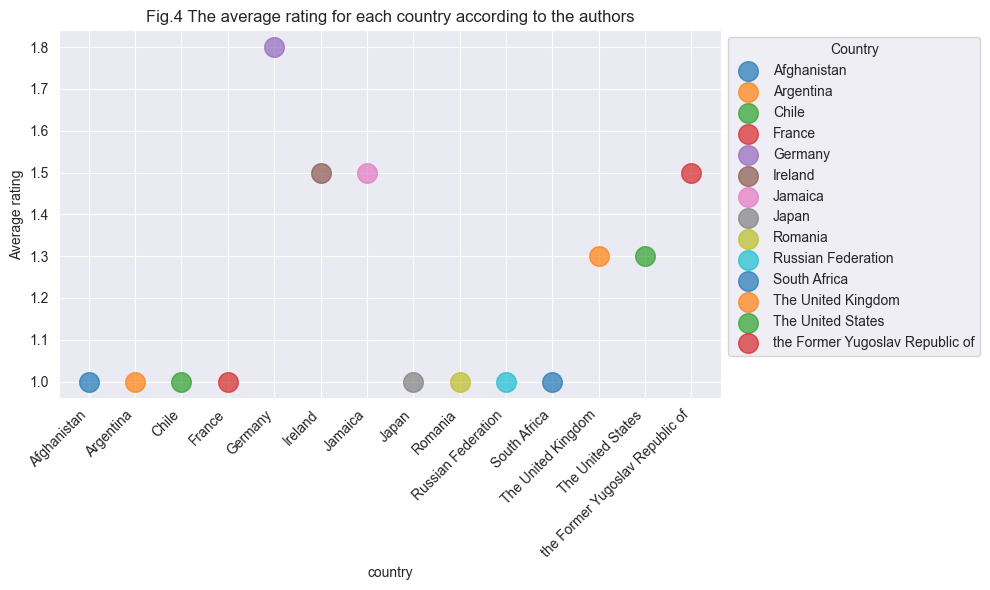

In [115]:
# Calculate average rate for each country
average_rating_by_country_df = pd.DataFrame(rate_country_df.groupby('country')['Rating'].mean().reset_index().round(1))

# Draw scatter plot
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
for i, row in average_rating_by_country_df.iterrows():
    plt.scatter(row['country'], row['Rating'], s=200, label=row['country'], alpha=0.7)

plt.xlabel('country')
plt.ylabel('Average rating')
plt.title('Fig.4 The average rating for each country according to the authors')
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

[Fig4] combines [Fig3] and [Fig1] to give users a more comprehensive understanding of which countries have more productive writers and which countries have more popular collections of famous quotes.

### Analysis of tags

Each quote on the site has several corresponding tags below it, and these tags are likely to become an important basis for users to make choices. Although the top 10 tags have been given on the right side of the page, it is still not worthy enough. Therefore, we need to do some processing on the tags.

In [72]:
tags_df = pd.DataFrame(pages_df['tags'].str.split(',', expand=True).stack())
tags_df.columns = ['tags']
element_counts = tags_df['tags'].value_counts()
tags_df['num_tag'] = tags_df['tags'].map(element_counts)
tags_df.index = range(1, len(tags_df)+1)
tags_df.head()

,tags,num_tag
1,change,1
2,deep-thoughts,1
3,thinking,2
4,world,1
5,abilities,1


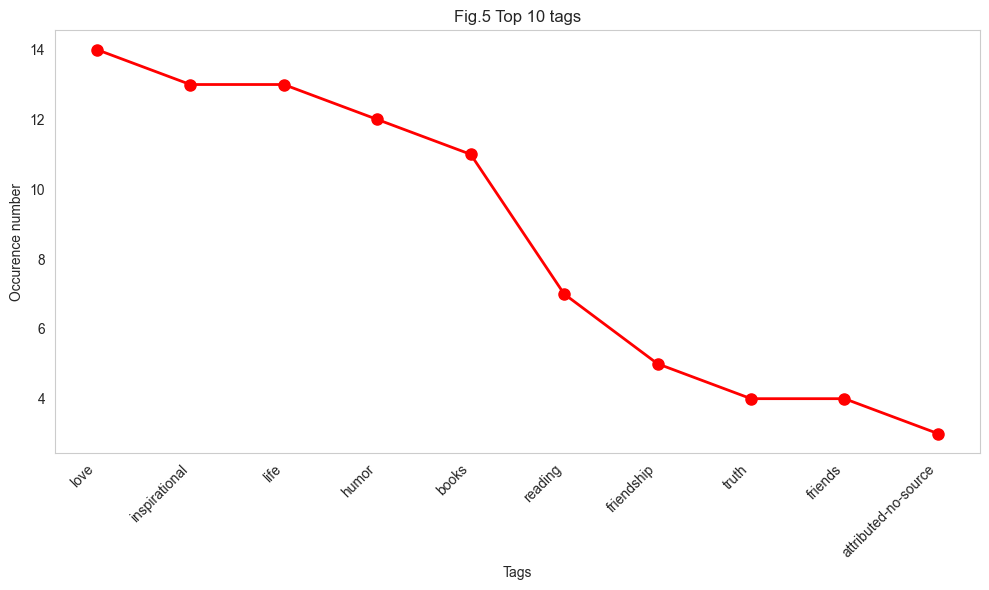

In [116]:
element_counts = tags_df['tags'].value_counts().nlargest(10)
# Draw the line plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(element_counts.index, element_counts.values, marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Tags')
plt.ylabel('Occurence number')
plt.title('Fig.5 Top 10 tags')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

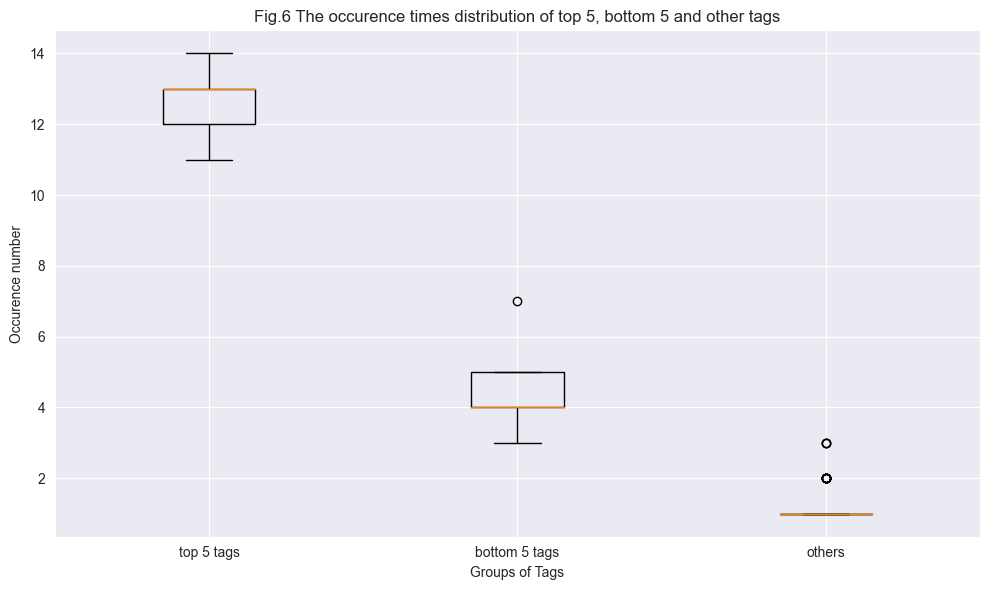

In [117]:
# Seperate the top 5 tags and the bottom 5 tags in the top 10 tags, and other tags
top5_elements = element_counts.head(5).index
bottom5_elements = element_counts.tail(5).index
other_elements = set(tags_df['tags'].unique()) - set(top5_elements) - set(bottom5_elements)
# Extract them
top5_data = tags_df[tags_df['tags'].isin(top5_elements)].drop_duplicates()
bottom5_data = tags_df[tags_df['tags'].isin(bottom5_elements)].drop_duplicates()
other_data = tags_df[tags_df['tags'].isin(other_elements)].drop_duplicates()

# Draw box plot
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
plt.boxplot([top5_data['num_tag'], bottom5_data['num_tag'], other_data['num_tag']], labels=['top 5 tags', 'bottom 5 tags', 'others'], vert=True)
plt.xlabel('Groups of Tags')
plt.ylabel('Occurence number')
plt.title('Fig.6 The occurence times distribution of top 5, bottom 5 and other tags')
plt.tight_layout()
plt.show()

According to the two graphs above, there is a big difference within the top 10 popular tags. The top five of these 10 tags correspond to far more quotes than the bottom five. That is, 'love', 'inspirational', 'life', 'humor' and 'books' are the most common topics. Users can clearly figure out from the above two images what the quotes from celebrity generally focuses on.

## Conclusion

By combing through the scraped information, we found that there are many correlations between the famous quotes and celebrities on the website. The era and country of the famous person also had some influence on the categories of quotes. If the user wants to choose to go to the bookstore to buy a collection of quotes suitable for him, then he can easily find the right direction from the above analysis.